In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/Landslide")

In [3]:
!pip install rasterio
!pip install pandas
!pip install geopandas
!pip install numpy
!pip install opencv-python
!pip install matplotlib
!pip install shapely
!pip install h5py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 58.2 MB/s eta 0:00:00


In [4]:
import os
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
#tf.random.set_seed(1234)

%matplotlib inline

# Train dataset

In [5]:
#Import raster and mask
raster_path = "N2017.jp2"
src = rasterio.open(raster_path)
raster_img = reshape_as_image(src.read())
raster_meta = src.meta

train_df = gpd.read_file("Nantou.shp")
train_df = train_df[~train_df.geometry.is_empty & train_df.geometry.notna()] #Remove rows without geometry
#train_df

In [6]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []

    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):

        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))

    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry'].geoms:  # Use geoms attribute to iterate over individual polygons
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)
np.unique(mask)

<ipython-input-6-c70abcbadbec>:7: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)


array([0, 1], dtype=uint8)

In [7]:
raster_img.shape

(23342, 21641, 3)

In [8]:
#divided image to 3 parts
height, width, channels = raster_img.shape
third_height = height // 3

top_section = raster_img[:third_height, :]
middle_section = raster_img[third_height:2*third_height, :]
bottom_section = raster_img[2*third_height:, :]

In [ ]:
plt.figure(figsize=(20, 30))

plt.subplot(311)
plt.imshow(cv2.cvtColor(top_section, cv2.COLOR_BGR2RGB))
plt.title('Top Section')

plt.subplot(312)
plt.imshow(cv2.cvtColor(middle_section, cv2.COLOR_BGR2RGB))
plt.title('Middle Section')

plt.subplot(313)
plt.imshow(cv2.cvtColor(bottom_section, cv2.COLOR_BGR2RGB))
plt.title('Bottom Section')

plt.tight_layout()
plt.show()

In [9]:
mask.shape

(23342, 21641)

In [10]:
#divided image to 3 parts
height, width = mask.shape
third_height = height // 3

top_mask = mask[:third_height, :]
middle_mask = mask[third_height:2*third_height, :]
bottom_mask = mask[2*third_height:, :]

In [ ]:
plt.figure(figsize=(20, 30))

plt.subplot(311)
plt.imshow(top_mask, cmap='gray')
plt.title('Top Section')

plt.subplot(312)
plt.imshow(middle_mask, cmap='gray')
plt.title('Middle Section')

plt.subplot(313)
plt.imshow(bottom_mask, cmap='gray')
plt.title('Bottom Section')

plt.tight_layout()
plt.show()

In [ ]:
#Split the large image into patches of 256x256
#patch_size = 256
#overlap = 128

# List to store small image patches
#X_train = []
#y_train = []
# Divide the large image into patches
#height, width, _ = top_section.shape

#for i in range(0, height - patch_size, overlap):
#    for j in range(0, width - patch_size, overlap):
#        patch = top_section[i:i+patch_size, j:j+patch_size]
#        X_train.append(patch)
#        patch1 = top_mask[i:i+patch_size, j:j+patch_size]
#        y_train.append(patch1)

# Display the number of patches created
#num_patches1 = len(X_train)
#print("Number of top patches:", num_patches1)
#num_patches2 = len(y_train)
#print("Number of top mask patches:", num_patches2)

In [11]:
#Split the large image into patches of 256x256
y_train = []
X_train = []
for i1 in range(0, len(top_mask) - 256, 128):
    for j1 in range(0, len(top_mask) - 256, 128):
        m1 = top_mask[i1: i1 + 256, j1: j1 + 256]
        r1 = top_section[i1: i1 + 256, j1: j1 + 256]
        _, counts = np.unique(m1, return_counts=True)

        if counts.size != 0 and (counts[0] / counts.sum() < 0.99):
            y_train.append(m1)
            X_train.append(r1)
len(X_train)

384

In [12]:
#Split the large image into patches of 256x256
y_valid = []
X_valid = []
for i1 in range(0, len(middle_mask) - 256, 256):
    for j1 in range(0, len(middle_mask) - 256, 256):
        m1 = middle_mask[i1: i1 + 256, j1: j1 + 256]
        r1 = middle_section[i1: i1 + 256, j1: j1 + 256]
        _, counts = np.unique(m1, return_counts=True)
        if counts.size != 0 and (counts[0] / counts.sum() < 0.99):
            y_valid.append(m1)
            X_valid.append(r1)

len(X_valid)

40

In [13]:
#Split the large image into patches of 256x256
y_test = []
X_test = []
for i2 in range(0, len(bottom_mask) - 256, 256):
    for j2 in range(0, len(bottom_mask) - 256, 256):
        m2 = bottom_mask[i2: i2 + 256, j2: j2 + 256]
        r2 = bottom_section[i2: i2 + 256, j2: j2 + 256]
        _, counts = np.unique(m2, return_counts=True)
        if counts.size != 0 and (counts[0] / counts.sum() < 0.99):
            y_test.append(m2)
            X_test.append(r2)

len(X_test)

8

In [ ]:
#Split the large image into patches of 256x256
#patch_size = 256
#overlap = 256

# List to store small image patches
#X_valid = []
#y_valid = []
# Divide the large image into patches
#height, width, _ = middle_section.shape

#for i in range(0, height - patch_size, overlap):
#    for j in range(0, width - patch_size, overlap):
#        patch = middle_section[i:i+patch_size, j:j+patch_size]
#        X_valid.append(patch)
#        patch1 = middle_mask[i:i+patch_size, j:j+patch_size]
#        y_valid.append(patch1)

# Display the number of patches created
#num_patches1 = len(X_valid)
#print("Number of middle patches:", num_patches1)
#num_patches2 = len(y_valid)
#print("Number of middle mask patches:", num_patches2)

In [ ]:
#Split the large image into patches of 256x256
#patch_size = 256
#overlap = 256

# List to store small image patches
#X_test = []
#y_test = []
# Divide the large image into patches
#height, width, _ = top_section.shape

#for i in range(0, height - patch_size, overlap):
#    for j in range(0, width - patch_size, overlap):
#        patch = bottom_section[i:i+patch_size, j:j+patch_size]
#        X_test.append(patch)
#        patch1 = bottom_mask[i:i+patch_size, j:j+patch_size]
#        y_test.append(patch1)

# Display the number of patches created
#num_patches1 = len(X_test)
#print("Number of bottom patches:", num_patches1)
#num_patches2 = len(y_test)
#print("Number of bottom mask patches:", num_patches2)

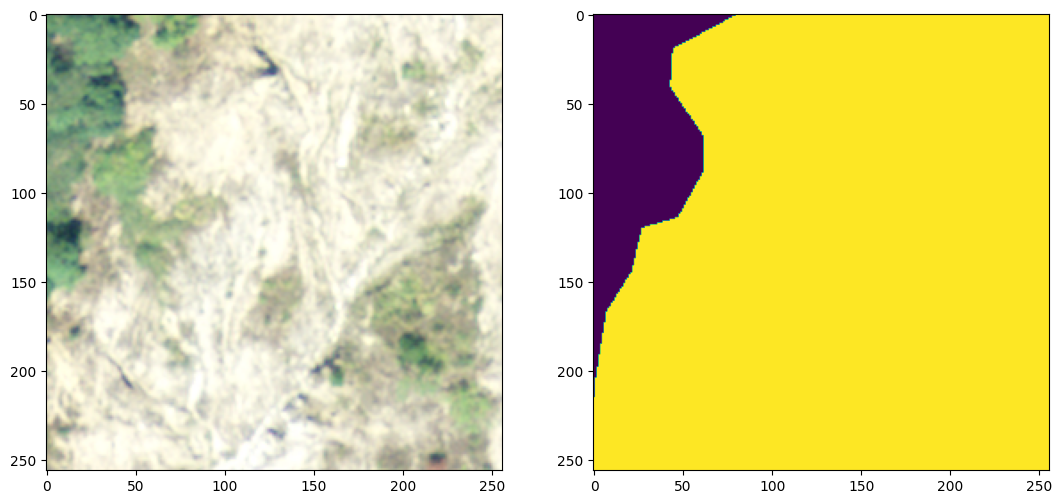

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.imshow(X_test[0])
plt.subplot(132)
plt.imshow(y_test[0])

plt.show()

In [ ]:
# y_train = masks[0:303]
# X_train = rasters[0:303]

# y_test = masks[303:606]
# X_test = rasters[303:606]

# y_valid = masks[606:909]
# X_valid = rasters[606:909]

# len(y_train), len(X_train),len(y_valid), len(X_valid),len(y_valid), len(X_valid)

In [14]:
#increase number of images by flipped and rotatated images
for i in range(len(y_train)):
    y_train.append(np.fliplr(y_train[i]))
    X_train.append(np.fliplr(X_train[i]))
for i in range(len(y_train)):
    y_train.append(np.rot90(y_train[i]))
    X_train.append(np.rot90(X_train[i]))
len(y_train), len(X_train)

(1536, 1536)

In [ ]:
#import tensorflow as tf
#model = tf.keras.models.load_model('Landslide_Unet_Largeimage.hdf5')

In [15]:
############### Unet model ##################

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    activation = 'sigmoid'

    outputs = Conv2D(1, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [16]:
input_shape = (256, 256, 3)
from keras import backend as K
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [17]:
from tensorflow.keras.metrics import MeanIoU

model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(rasters, masks, test_size = 0.1)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1)

In [18]:
#Check the array of each images after divided
for index, element in enumerate(y_valid):
   print(f"Shape of element {index + 1}: {element.shape}")

Shape of element 1: (256, 256)
Shape of element 2: (256, 256)
Shape of element 3: (256, 256)
Shape of element 4: (256, 256)
Shape of element 5: (256, 256)
Shape of element 6: (256, 256)
Shape of element 7: (256, 256)
Shape of element 8: (256, 256)
Shape of element 9: (256, 256)
Shape of element 10: (256, 256)
Shape of element 11: (256, 256)
Shape of element 12: (256, 256)
Shape of element 13: (256, 256)
Shape of element 14: (256, 256)
Shape of element 15: (256, 256)
Shape of element 16: (256, 256)
Shape of element 17: (256, 256)
Shape of element 18: (256, 256)
Shape of element 19: (256, 256)
Shape of element 20: (256, 256)
Shape of element 21: (256, 256)
Shape of element 22: (256, 256)
Shape of element 23: (256, 256)
Shape of element 24: (256, 256)
Shape of element 25: (256, 256)
Shape of element 26: (256, 256)
Shape of element 27: (256, 256)
Shape of element 28: (256, 256)
Shape of element 29: (256, 256)
Shape of element 30: (256, 256)
Shape of element 31: (256, 256)
Shape of element 

In [ ]:
# #Only keep the image with them same size 256z256
# X_test = [arr for arr in X_test if arr.shape == (256,256,3)]
# y_test = [arr for arr in y_test if arr.shape == (256,256)]
# X_train = [arr for arr in X_train if arr.shape == (256,256,3)]
# y_train = [arr for arr in y_train if arr.shape == (256,256)]
# X_valid = [arr for arr in X_valid if arr.shape == (256,256,3)]
# y_valid = [arr for arr in y_valid if arr.shape == (256,256)]

In [19]:
tf.random.set_seed(29)

In [20]:
#from tensorflow.keras.callbacks import EarlyStopping
v_data = (np.array(X_valid), np.array(y_valid))
history = model.fit(np.array(X_train), np.array(y_train),
                    batch_size = 16,
                    verbose=1,
                    epochs=50,
                    validation_data=v_data,
                    shuffle=False)
                    #callbacks=[EarlyStopping(patience=10)])

model.save('Landslide_Unet_Largeimage.hdf5')

Epoch 1/50
96/96 [==============================] - 135s 894ms/step - loss: 0.3310 - mean_io_u: 0.3405 - val_loss: 0.7573 - val_mean_io_u: 0.4166
Epoch 2/50
96/96 [==============================] - 78s 816ms/step - loss: 0.2786 - mean_io_u: 0.3403 - val_loss: 0.6070 - val_mean_io_u: 0.3289
Epoch 3/50
96/96 [==============================] - 78s 810ms/step - loss: 0.2606 - mean_io_u: 0.3403 - val_loss: 0.5269 - val_mean_io_u: 0.3289
Epoch 4/50
96/96 [==============================] - 78s 817ms/step - loss: 0.2512 - mean_io_u: 0.3403 - val_loss: 0.2404 - val_mean_io_u: 0.3289
Epoch 5/50
96/96 [==============================] - 78s 815ms/step - loss: 0.2401 - mean_io_u: 0.3403 - val_loss: 0.2577 - val_mean_io_u: 0.3289
Epoch 6/50
96/96 [==============================] - 78s 811ms/step - loss: 0.2328 - mean_io_u: 0.3403 - val_loss: 0.2698 - val_mean_io_u: 0.3289
Epoch 7/50
96/96 [==============================] - 78s 817ms/step - loss: 0.2226 - mean_io_u: 0.3403 - val_loss: 0.2834 - val_me

In [21]:
preds= model.predict(np.array(X_test))

1/1 [==============================] - 0s 431ms/step


In [22]:
pred_bin = preds[:, :, :, 0] > 0.5
loss = MeanIoU(num_classes=2)
loss.update_state(y_test, pred_bin)
loss.result().numpy()

0.78316337

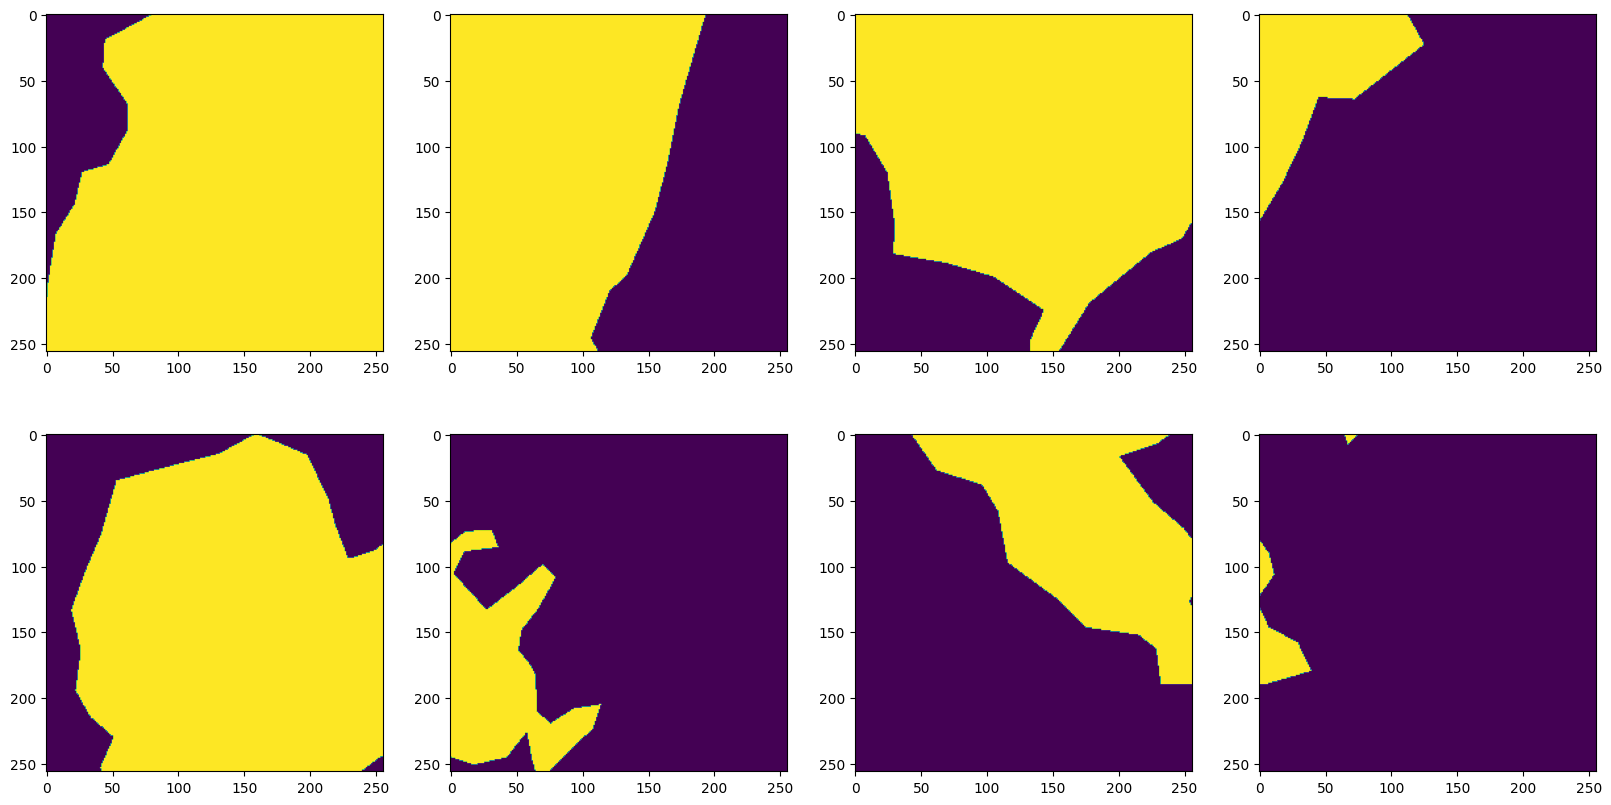

In [23]:
f, axarr = plt.subplots(2, 4)
f.set_size_inches(20, 10)
for i in range(len(y_test)):
  axarr[i // 4, i % 4].imshow(y_test[i])

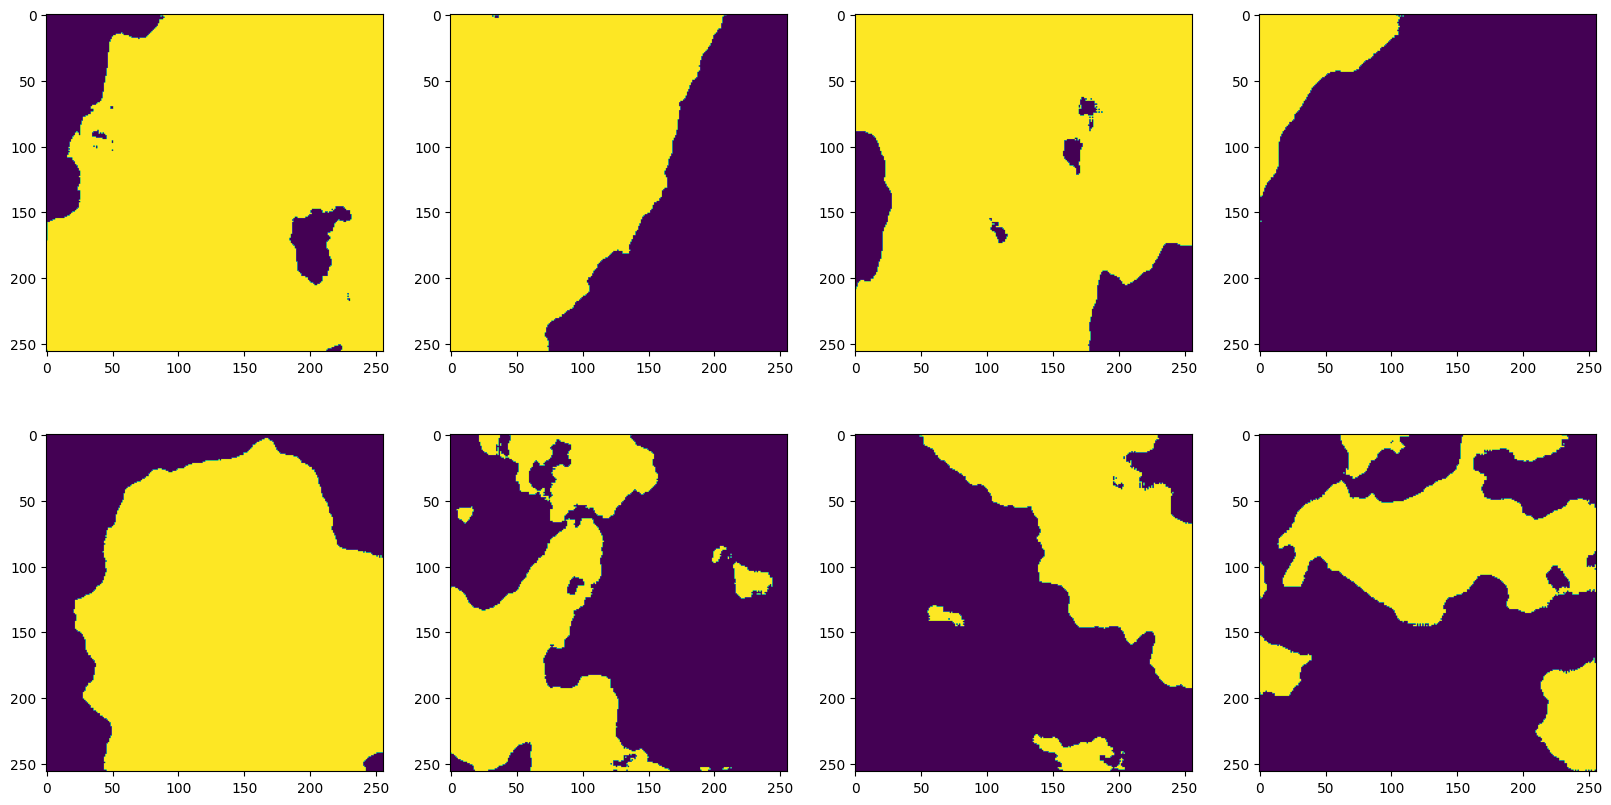

In [24]:
f, axarr = plt.subplots(2, 4)
f.set_size_inches(20, 10)
for i in range(len(preds)):
  axarr[i // 4, i % 4].imshow(preds[i][:, :] > 0.5)

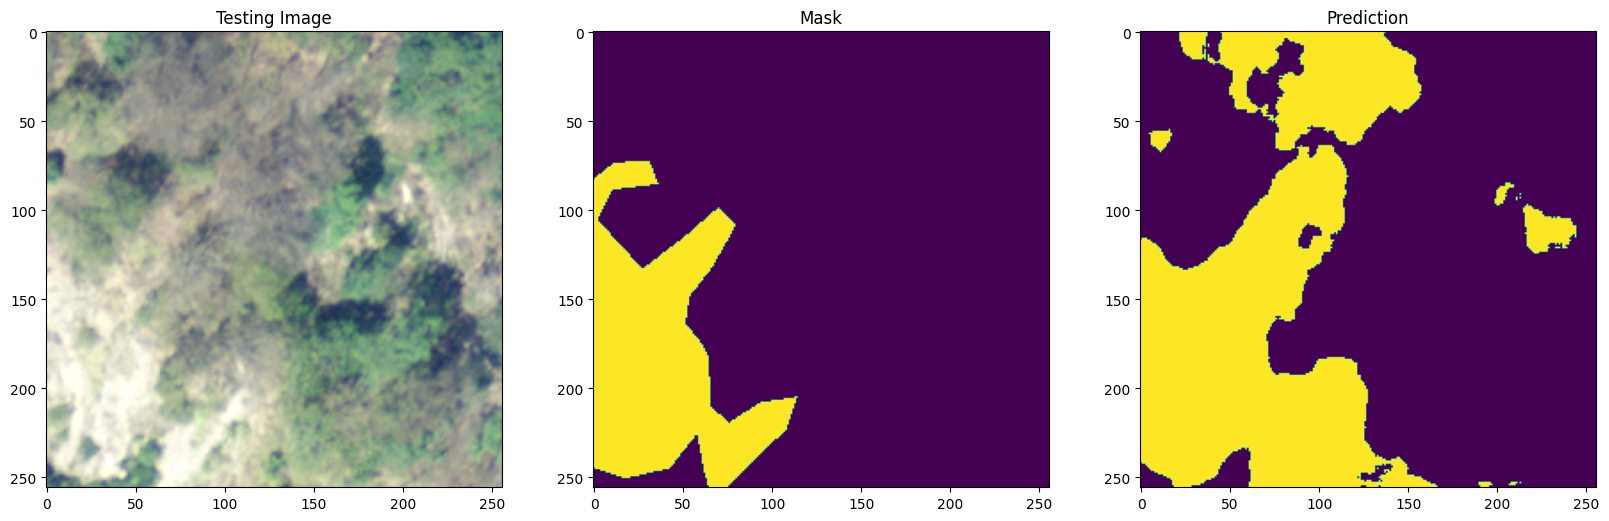

In [25]:
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(X_test[5])
plt.subplot(132)
plt.title('Mask')
plt.imshow(y_test[5])
plt.subplot(133)
plt.title('Prediction')
plt.imshow(preds[5][:, :] > 0.5)

plt.show()

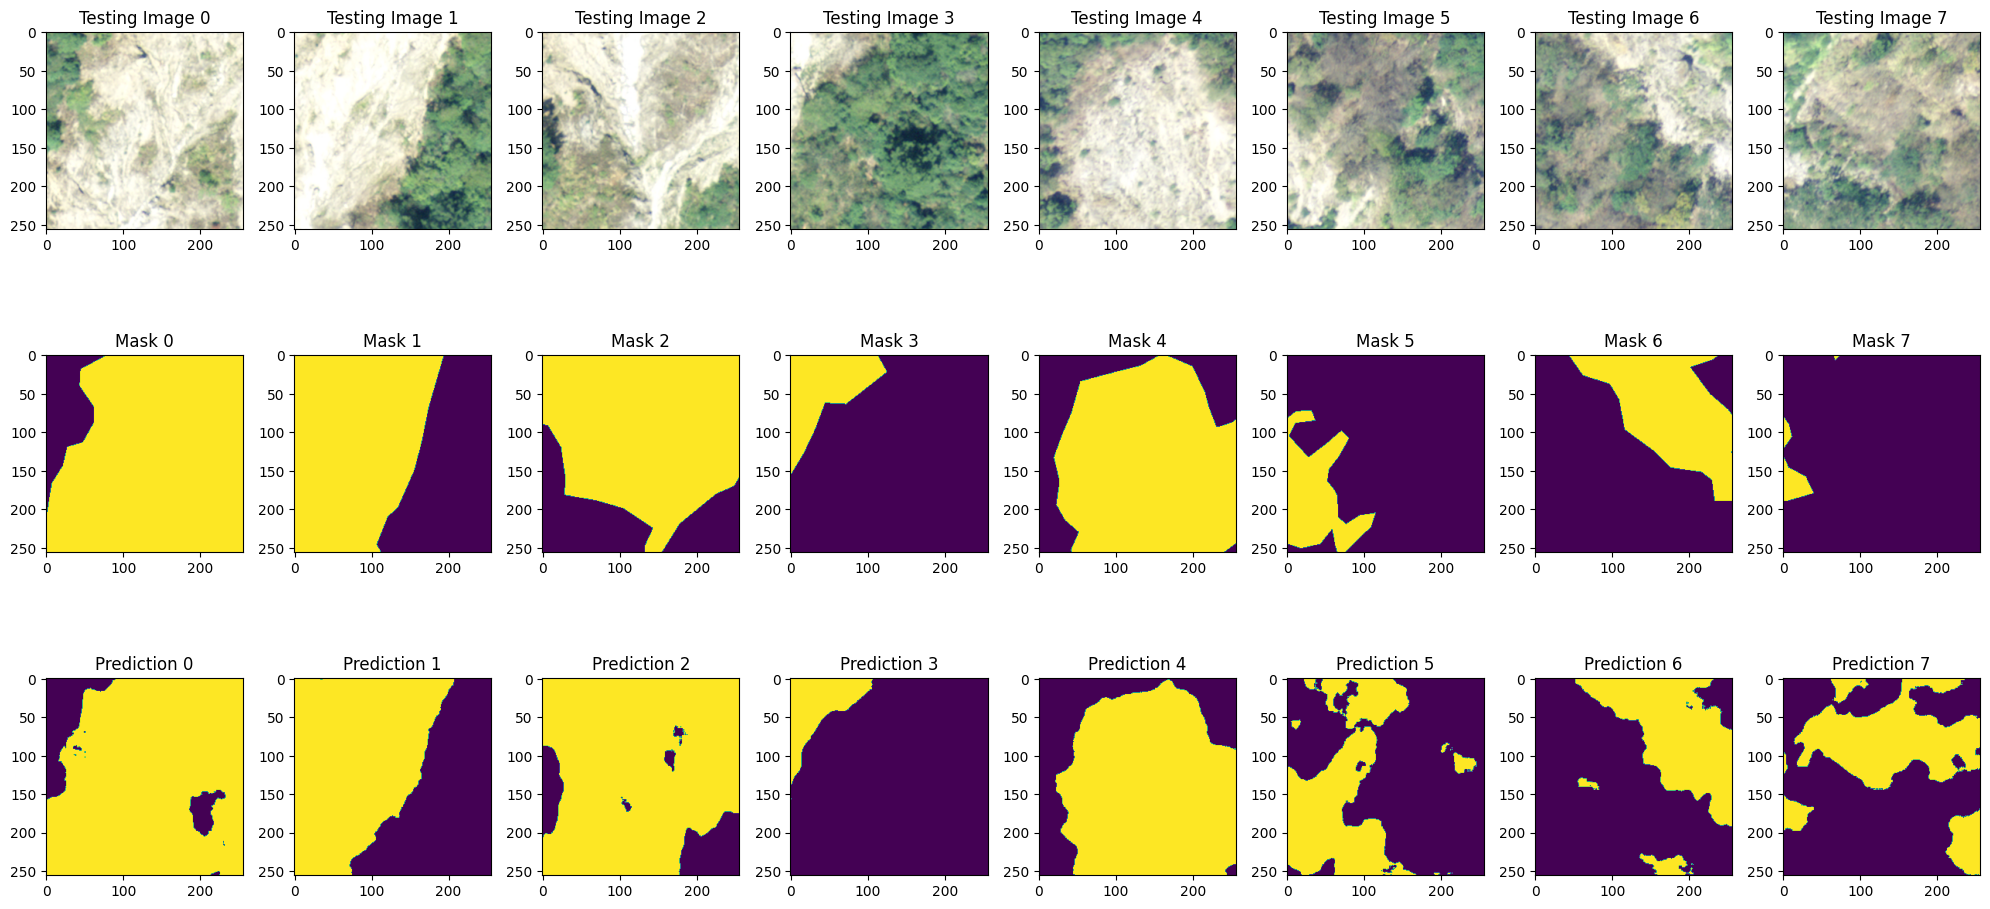

In [26]:
import matplotlib.pyplot as plt

num_images = len(X_test)  # 總共的數量

plt.figure(figsize=(20, 10))

for i in range(num_images):
    plt.subplot(3, num_images, i + 1)
    plt.title(f'Testing Image {i}')
    plt.imshow(X_test[i])
    # plt.axis('off')

    plt.subplot(3, num_images, num_images + i + 1)
    plt.title(f'Mask {i}')
    plt.imshow(y_test[i])
    # plt.axis('off')

    plt.subplot(3, num_images, 2 * num_images + i + 1)
    plt.title(f'Prediction {i}')
    plt.imshow(preds[i][:, :] > 0.5)
    # plt.axis('off')

plt.tight_layout()
plt.show()

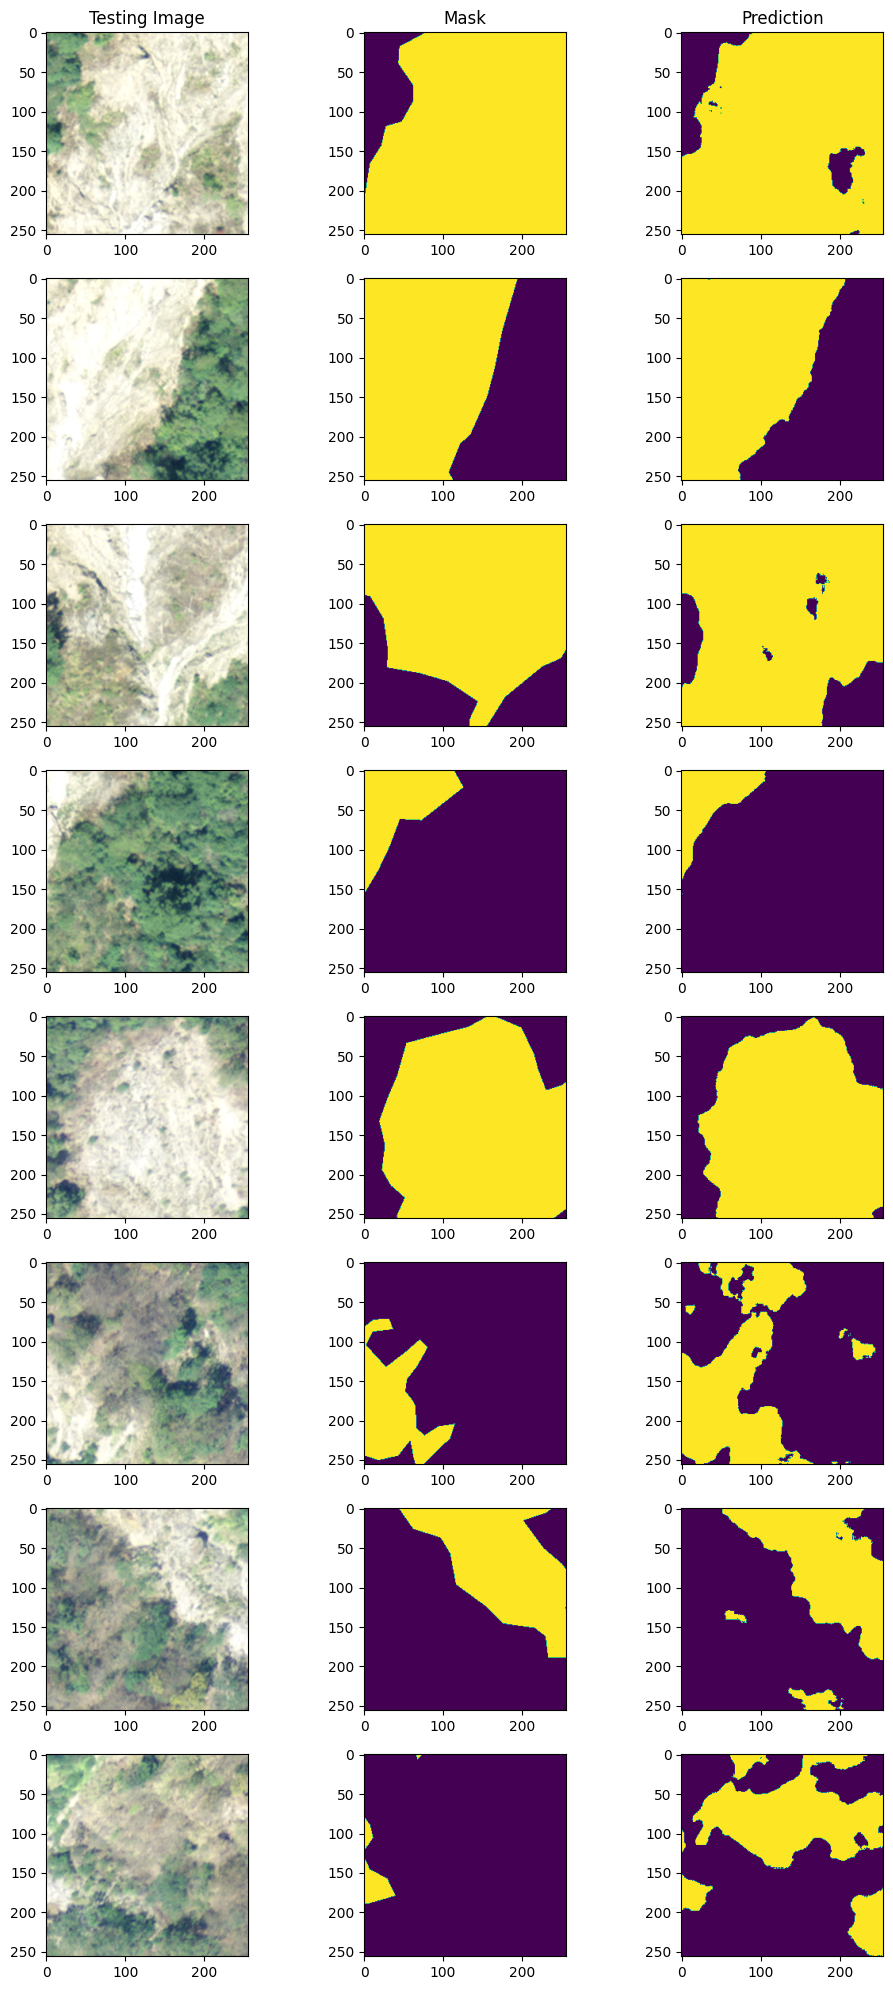

In [27]:
import matplotlib.pyplot as plt

num_images = len(X_test)  # 總共的數量

plt.figure(figsize=(10, 20))  # 設定整體圖片的大小

for i in range(num_images):
    plt.subplot(num_images, 3, i * 3 + 1)
    if i == 0:
      plt.title('Testing Image')
    plt.imshow(X_test[i])
    #plt.axis('off')

    plt.subplot(num_images, 3, i * 3 + 2)
    if i == 0:
      plt.title('Mask')
    plt.imshow(y_test[i])
    #plt.axis('off')

    plt.subplot(num_images, 3, i * 3 + 3)
    if i == 0:
      plt.title('Prediction')
    plt.imshow(preds[i][:, :] > 0.5)
    #plt.axis('off')
#plt.subplots_adjust(hspace=0.01)
plt.tight_layout()
#plt.savefig("reault_image.png")

plt.show()

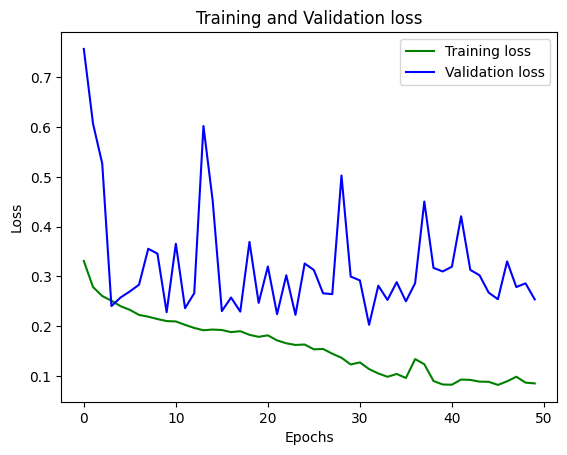

In [28]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def  precision_score_ ( y_test, preds ):
    intersect = np. sum (preds*y_test)
    total_pixel_pred = np. sum (preds)
    precision = np.mean(intersect/total_pixel_pred)
    return  round ( precision, 3 )

precision = precision_score_(y_test, preds)
print("Precision:", precision)

In [ ]:
def  recall_score_ ( y_test, preds ):
    intersect = np. sum (preds* y_test)
    total_pixel_truth = np. sum ( y_test)
    recall = np.mean(intersect/total_pixel_truth)
    return  round (recall, 3)

recall = recall_score_(y_test, preds)
print("Recall:", recall)

In [ ]:
# 訓練/測試分割
x_train, x_test, y_train, y_test = train_test_split(df.hoursOfStudy, df.passing, test_size=0.4, random_state=321)
# 重塑訓練數據的獨立變量
x_train_array = np.array(x_train).reshape(-1,1)
# 建立模型
logistic = LogisticRegression()
# 擬合模型
model = Logistic.fit(x_train_array, y_train)
# 重塑測試數據的獨立變量
x_test_array = np.array(x_test).reshape(-1,1)
# 進行預測
y_pred = model.predict(x_test_array)
# 計算混淆矩陣並賦值給變量
tn, fp, fn, tp = fusion_matrix(y_test, y_pred).ravel()

In [ ]:
# 計算準確度得分
#1. 手動計算 - tp+tn: #正確分類的數據
#print((tp+tn)/(tn+fn+fp+tp))
#2.使用accuracy_score函數
print( accuracy_score (y_test, preds))